# Credit card fraud detection

This project focuses on creating a machine learning model, which would allow to predict credit card fraud using the
Kaggle dataset - https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import  ttest_ind, pearsonr, spearmanr, mannwhitneyu, randint
from sklearn.metrics import (roc_curve, accuracy_score, confusion_matrix, recall_score, precision_score,
                             roc_auc_score, precision_recall_curve, auc, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
import pandas
import numpy
import pickle
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

sns.set(style="darkgrid")
numpy.set_printoptions(suppress=True)

## Data Exploration

In [3]:
SEED = 0
JOBS = 10

In [4]:
types = {f'V{i}': 'float32' for i in range(1, 29)}
types['Amount'] = 'float32'
types['Time'] = 'int32'
types

{'V1': 'float32',
 'V2': 'float32',
 'V3': 'float32',
 'V4': 'float32',
 'V5': 'float32',
 'V6': 'float32',
 'V7': 'float32',
 'V8': 'float32',
 'V9': 'float32',
 'V10': 'float32',
 'V11': 'float32',
 'V12': 'float32',
 'V13': 'float32',
 'V14': 'float32',
 'V15': 'float32',
 'V16': 'float32',
 'V17': 'float32',
 'V18': 'float32',
 'V19': 'float32',
 'V20': 'float32',
 'V21': 'float32',
 'V22': 'float32',
 'V23': 'float32',
 'V24': 'float32',
 'V25': 'float32',
 'V26': 'float32',
 'V27': 'float32',
 'V28': 'float32',
 'Amount': 'float32',
 'Time': 'int32'}

In [5]:
data = pandas.read_csv('./data/creditcard.csv', header=0, dtype=types)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  int32  
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.339397e-08,0.000000,-4.800400e-08,6.643411e-09,2.657364e-08,-1.500125e-09,-1.071518e-09,-1.071518e-10,-3.214554e-10,...,-1.928732e-09,3.643161e-09,3.214554e-10,1.259033e-09,2.143036e-09,1.034684e-09,1.138488e-10,-1.272427e-10,88.349609,0.001727
std,47488.145955,1.958696e+00,1.651309,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120117,0.041527
min,0.000000,-5.640751e+01,-72.715729,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-0.598550,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,0.065486,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097605e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,0.803724,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273458e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165001,0.000000
max,172792.000000,2.454930e+00,22.057730,9.382559e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519588e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160156,1.000000


In [8]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
data.drop(columns='Time', inplace=True)

/home/vladimir/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/vladimir/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


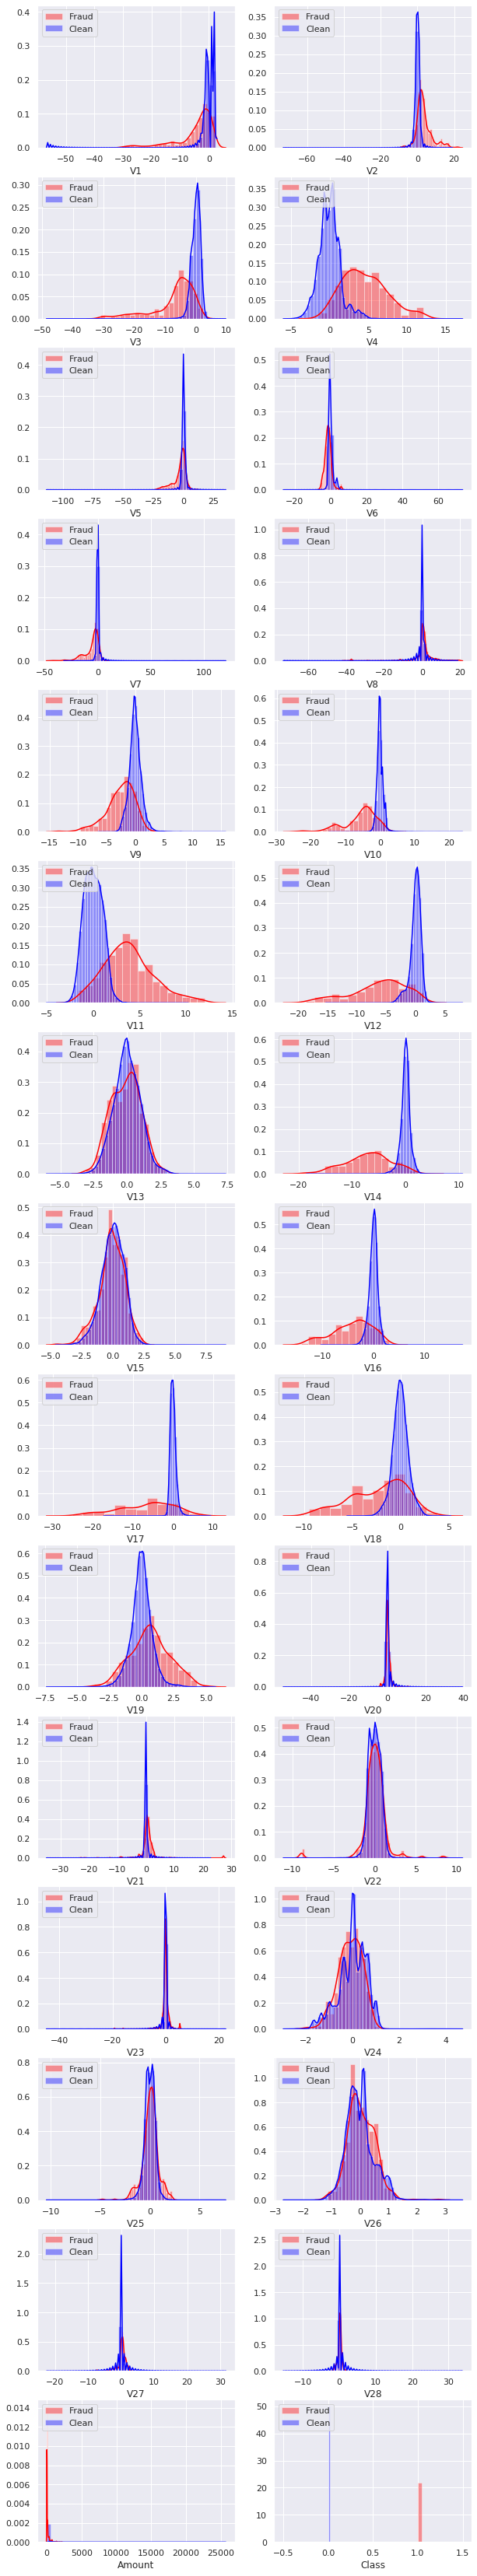

In [10]:
rows, cols = 15, 2
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 60))
idx=0
for i in range(rows):
    for k in range(cols):
        pos = data.iloc[:, idx].where(data['Class']==1)
        neg = data.iloc[:, idx].where(data['Class']==0)
        sns.distplot(pos, ax=ax[i, k], color='red', label='Fraud')
        sns.distplot(neg, ax=ax[i, k], color='blue', label='Clean')
        ax[i, k].legend(loc='upper left')
        idx+=1

plt.show()

(0, 1000)

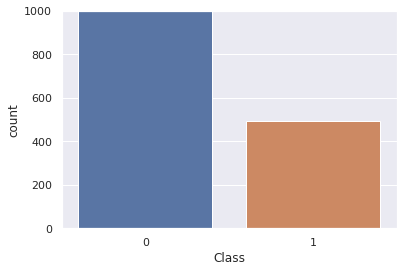

In [11]:
plt.figure(1)
sns.countplot(x='Class', data=data)
plt.ylim([0, 1000])

In [12]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
X = data.loc[:, 'V1':'Amount']
y = data.loc[:, 'Class']

In [17]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998


In [18]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [21]:
import hytests
from importlib import reload
reload(hytests)
from hytests import Hypot

tester = Hypot()
mapping = {f'V{i}': 'cont' for i in range(1, 29)}
mapping['Amount'] = 'cont'
p = tester.test(data=X, mapping=mapping)



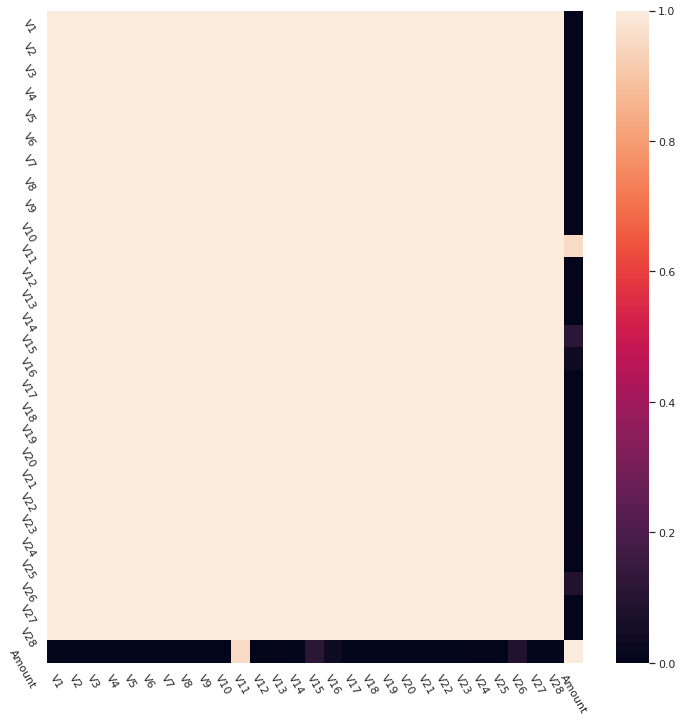

In [22]:
plt.figure(figsize=(12,12))
sns.heatmap(data=p, vmin=0, vmax=1)
plt.yticks(rotation=300)
plt.xticks(rotation=300)
plt.show()


## Model Exploration



In [14]:
def ml_pipeline(model, X, y, n_splits):

    X = X.to_numpy()
    y = y.to_numpy()

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cm = []
    recalls = []
    precisions = []
    aps = []
    auc_roc = 0
    fpr = numpy.linspace(0, 1, 100)
    tpr = []
    rec = numpy.linspace(0, 1, 100)
    prec = []

    for train_index, test_index in cv.split(X=X, y=y):

        model.fit(X=X[train_index], y=y[train_index])

        y_pred = model.predict(X[test_index])
        y_probs = model.predict_proba(X[test_index])[:, 1]

        cm_ = confusion_matrix(y_true=y[test_index], y_pred=y_pred, labels=[1, 0])
        cm.append(cm_)

        precision_ = precision_score(y_true=y[test_index], y_pred=y_pred, labels=[1, 0])
        precisions.append(precision_)

        recall_ = recall_score(y_true=y[test_index], y_pred=y_pred, labels=[1, 0])
        recalls.append(recall_)

        auc_roc_ = roc_auc_score(y_true=y[test_index], y_score=y_probs, labels=[1, 0])
        auc_roc += auc_roc_

        fpr_, tpr_, _ = roc_curve(y_true=y[test_index], y_score=y_probs, pos_label=1)
        tpr_i = numpy.interp(fpr, fpr_, tpr_)
        tpr_i[0] = 0
        tpr.append(tpr_i)

        prec_, rec_, _ = precision_recall_curve(y_true=y[test_index], probas_pred=y_probs, pos_label=1)
        prec_i = numpy.interp(rec, rec_[::-1], prec_[::-1])
        prec.append(prec_i)

        ap_ = average_precision_score(y_true=y[test_index], y_score=y_probs)
        aps.append(ap_)

    cm = numpy.mean(cm, axis=0)
    recall = round(sum(recalls)/n_splits, 3)
    precision = round(sum(precisions)/n_splits, 3)
    ap = round(sum(aps)/n_splits, 3)
    auc_roc = round(auc_roc/n_splits, 3)
    prec = numpy.mean(prec, axis=0)
    auc_pr = round(auc(rec, prec), 3)
    tpr = numpy.mean(tpr, axis=0)

    metrics = {'recall': recall, 'precision': precision, 'aucROC': auc_roc, 'aucPR': auc_pr, 'cm': cm, 'ap': ap}
    roc = {'tpr': tpr, 'fpr': fpr}
    pr = {'precision': prec, 'recall': rec}
    stats = {'average_precision': aps}

    return metrics, roc, pr, stats

In [15]:
def ml_run(models, colors, names, n_splits):

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    run_stats = {}
    cms = {}

    for idx, model in enumerate(models):
        metrics, roc, pr, stats = ml_pipeline(model=model,
                                              X=X,
                                              y=y,
                                              n_splits=n_splits)
        sns.lineplot(x=roc['fpr'], y=roc['tpr'], ax=ax[0], color=colors[idx], label=names[idx])
        sns.lineplot(x=pr['recall'], y=pr['precision'], ax=ax[1], color=colors[idx], label=names[idx])
        print(f'{names[idx]} - recall: {metrics["recall"]}, precision: {metrics["precision"]},'
          f' aucROC: {metrics["aucROC"]}, aucPR: {metrics["aucPR"]}, ap: {metrics["ap"]}')
        run_stats[names[idx]] = stats
        cms[names[idx]] = metrics['cm']

    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')
    ax[1].set_ylabel('Precision')
    ax[1].set_xlabel('Recall')
    plt.legend()
    plt.show()

    return cms, run_stats


In [16]:
models = [LogisticRegression(random_state=SEED, n_jobs=JOBS),
          RandomForestClassifier(random_state=SEED, n_jobs=JOBS),
          XGBClassifier(random_state=SEED, n_jobs=JOBS),
          GaussianNB()
         ]
colors = ['blue', 'red', 'purple', 'green']
names = ['LR', 'RF', 'XGB', 'NB']

LR - recall: 0.63, precision: 0.843, aucROC: 0.955, aucPR: 0.718, ap: 0.722
RF - recall: 0.776, precision: 0.955, aucROC: 0.948, aucPR: 0.85, ap: 0.846
XGB - recall: 0.797, precision: 0.954, aucROC: 0.979, aucPR: 0.857, ap: 0.862
NB - recall: 0.829, precision: 0.061, aucROC: 0.961, aucPR: 0.428, ap: 0.086


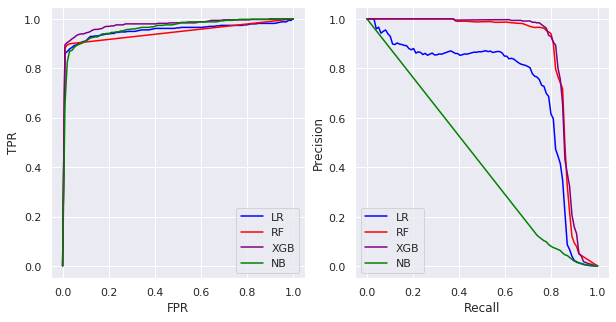

In [17]:
cms, run_stats = ml_run(models=models, colors=colors, names=names, n_splits=5)

In [18]:
combos = list(combinations(run_stats.keys(), r=2))
for m1, m2 in combos:
    _, pap = ttest_ind(run_stats[m1]['average_precision'], run_stats[m2]['average_precision'])
    print(m1 + '-' + m2 + ' ' + f'p_value: {pap:0.5f}')

LR-RF p_value: 0.00121
LR-XGB p_value: 0.00073
LR-NB p_value: 0.00000
RF-XGB p_value: 0.23189
RF-NB p_value: 0.00000
XGB-NB p_value: 0.00000


In [19]:
columns = ['TruePositive', 'FalseNegative', 'FalsePositive', 'TrueNegative']
def array2list(arr): return arr.flatten().tolist()
confs = pandas.DataFrame(data=numpy.array([array2list(cms[name]) for name in names]),
                         index=names,
                         columns=columns)
confs

,TruePositive,FalseNegative,FalsePositive,TrueNegative
LR,62.0,36.4,11.6,56851.4
RF,76.4,22.0,3.6,56859.4
XGB,78.4,20.0,3.8,56859.2
NB,81.6,16.8,1245.6,55617.4


## Model Tuning


### Recursive Feature Elimination

In [12]:

rfe_recall = pickle.load(open('./data/rfe.pkl', 'rb'))
rfe_precision = pickle.load(open('./data/rfe_precision.pkl', 'rb'))

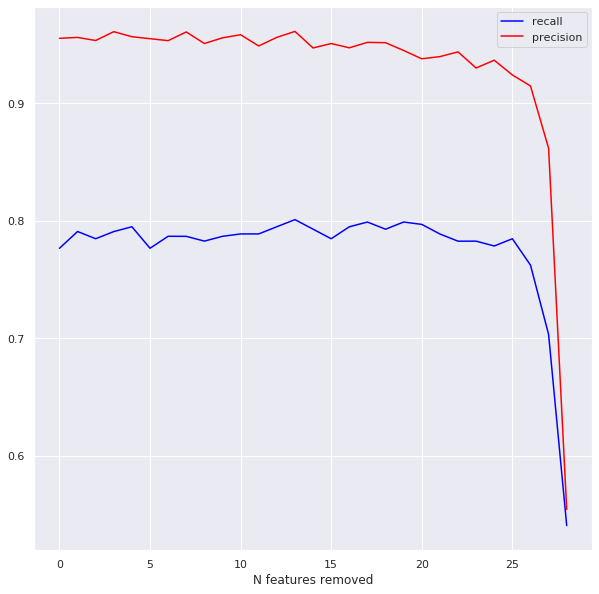

In [13]:
plt.figure(figsize=(10,10))
sns.lineplot(x=range(len(X.columns)), y=rfe_recall.grid_scores_[::-1], color='blue', label='recall')
sns.lineplot(x=range(len(X.columns)), y=rfe_precision.grid_scores_[::-1], color='red', label='precision')
plt.xlabel('N features removed')
plt.legend()
plt.show()

In [17]:
for i in range(len(rfe_recall.grid_scores_)):
    print(f'{i+1} features, recall: {rfe_recall.grid_scores_[i]:0.4f}, '
          f'precision: {rfe_precision.grid_scores_[i]:0.4f}')

1 features, recall: 0.5407, precision: 0.5543
2 features, recall: 0.7033, precision: 0.8616
3 features, recall: 0.7622, precision: 0.9146
4 features, recall: 0.7846, precision: 0.9240
5 features, recall: 0.7785, precision: 0.9365
6 features, recall: 0.7826, precision: 0.9299
7 features, recall: 0.7826, precision: 0.9436
8 features, recall: 0.7887, precision: 0.9395
9 features, recall: 0.7968, precision: 0.9377
10 features, recall: 0.7989, precision: 0.9447
11 features, recall: 0.7927, precision: 0.9514
12 features, recall: 0.7988, precision: 0.9517
13 features, recall: 0.7948, precision: 0.9470
14 features, recall: 0.7846, precision: 0.9507
15 features, recall: 0.7928, precision: 0.9469
16 features, recall: 0.8009, precision: 0.9610
17 features, recall: 0.7948, precision: 0.9559
18 features, recall: 0.7887, precision: 0.9486
19 features, recall: 0.7887, precision: 0.9582
20 features, recall: 0.7867, precision: 0.9555
21 features, recall: 0.7826, precision: 0.9507
22 features, recall: 0

In [32]:
columns = [name for name, mask in zip(X.columns, rfe_recall.support_) if mask == True]
X_ = X[columns]
X_.head()

,V1,V3,V4,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V20,V21,V26
0,-1.359807,2.536347,1.378155,0.462388,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.251412,-0.018307,-0.189115
1,1.191857,0.166480,0.448154,-0.082361,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.069083,-0.225775,0.125895
2,-1.358354,1.773209,0.379780,1.800499,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0.524980,0.247998,-0.139097
3,-0.966272,1.792993,-0.863291,1.247203,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-0.208038,-0.108300,-0.221929
4,-1.158233,1.548718,0.403034,0.095921,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.408542,-0.009431,0.502292


### Hyperparameter Tuning

In [55]:
rf = RandomForestClassifier(random_state=SEED)

params = {'n_estimators': randint(1, 201),
          'max_depth': randint(2, 61),
          'min_samples_split': randint(2, 101),
          'min_samples_leaf': randint(1, 51),
          'max_features': randint(2, 30)
          }

search = RandomizedSearchCV(estimator=rf,
                            param_distributions=params,
                            n_iter=100,
                            n_jobs=JOBS,
                            cv=StratifiedKFold(random_state=SEED, shuffle=True, n_splits=5),
                            verbose=10,
                            random_state=SEED,
                            scoring={'AP': 'average_precision', 'Recall': 'recall', 'Precision': 'precision'},
                            refit=False,
                            return_train_score=True,
                            error_score='raise'
                            )

In [27]:
search.fit(X.to_numpy(), y.to_numpy().reshape(-1, ))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  8.3min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 21.3min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 32.7min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 35.7min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 40.1min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 51.2min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 65.5min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 86.6min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 92.4min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 109.2min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 122.2min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed: 146.5min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 153.2min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapse

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(random_state=0), n_iter=100,
                   n_jobs=10,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f32c820e590>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f32c81e4710>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f32c820e950>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f32c820eb10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f32c81cc490>},
                   random_state=0, refit=False, return_train_score=True,
                   scoring={'AP': 'average_precision', 'Precision': 'precision',
                            'Recall': 'rec

In [63]:
res = pandas.DataFrame(search.cv_results_)


AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

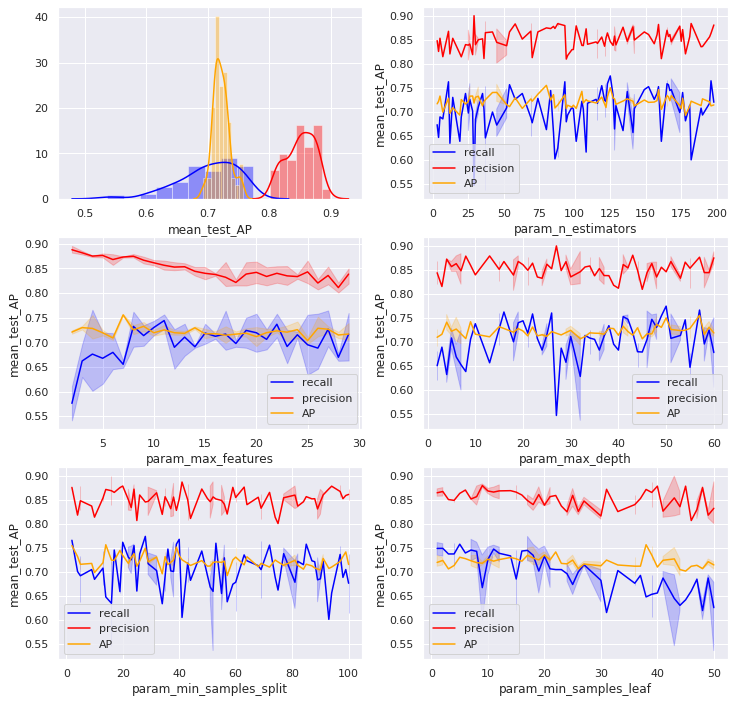

In [78]:
rows, cols = 3, 2
params = ['param_max_features', 'param_max_depth',
          'param_min_samples_split', 'param_min_samples_leaf']

f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
sns.distplot(res['mean_test_Recall'], color='blue', label='recall', ax=ax[0,0])
sns.distplot(res['mean_test_Precision'], color='red', label='precision', ax=ax[0,0])
sns.distplot(res['mean_test_AP'], color='orange', label='ap', ax=ax[0,0])
sns.lineplot(x=res['param_n_estimators'], y=res['mean_test_Recall'], ax=ax[0,1], color='blue', label='recall')
sns.lineplot(x=res['param_n_estimators'], y=res['mean_test_Precision'], ax=ax[0,1], color='red', label='precision')
sns.lineplot(x=res['param_n_estimators'], y=res['mean_test_AP'], ax=ax[0,1], color='orange', label='AP')

idx=0
for i in range(1, rows):
    for k in range(cols):
        sns.lineplot(x=res[params[idx]], y=res['mean_test_Recall'], ax=ax[i,k], color='blue', label='recall')
        sns.lineplot(x=res[params[idx]], y=res['mean_test_Precision'], ax=ax[i,k], color='red', label='precision')
        sns.lineplot(x=res[params[idx]], y=res['mean_test_AP'], ax=ax[i,k], color='orange', label='AP')
        idx+=1

plt.legend()
plt.show()

In [74]:
sorted = res.sort_values(by=['mean_test_Recall'], ascending=False)
best_params = sorted[['param_n_estimators', 'param_max_features', 'param_max_depth',
                      'param_min_samples_split', 'param_min_samples_leaf']]
best_params

,param_n_estimators,param_max_features,param_max_depth,param_min_samples_split,param_min_samples_leaf
86,125,29,50,28,17
88,168,27,15,40,7
11,165,4,57,2,1
0,196,17,46,69,1
68,93,8,19,20,8
...,...,...,...,...,...
3,88,3,60,41,39
66,86,4,55,93,48
80,182,2,7,81,9
77,29,2,27,16,43


### Best Fit Training & Evaluation

In [15]:
tuned = RandomForestClassifier(n_estimators=125,
                               max_features=29,
                               max_depth=50,
                               min_samples_split=28,
                               min_samples_leaf=17,
                               random_state=SEED,
                               n_jobs=JOBS,
                               )

base = RandomForestClassifier(random_state=SEED,
                               n_jobs=JOBS)

In [ ]:
cms, run_stats = ml_run(models=[tuned, base],
                        colors=['blue', 'red'],
                        names=['tuned', 'base'],
                        n_splits=5)